In [1]:
#indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/cell_by_var/"
# indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/cells_vars/vcfpad_1"
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/cells_meta.tsv"
# outdir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/som_clones/"
# condition = "Control"
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/needle/peaks_all/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/needle/peaks_all/merge/"
vars_f = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/variants.annotate.gene.vcf"


clones_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
clone_sizes_in_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1/clone_sizes.csv"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/barcodes/btwnClones/"
# DONOR = 1
# clones_meta = '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/results/clones_summary/feb23_2022/clones_summary.csv'



In [2]:
from glob import glob
from os.path import basename, join
from src.utils.data_io import read_csv_multichar
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
import mplh.cluster_help as ch
import matplotlib.pyplot as plt
import scipy
%load_ext autoreload
%autoreload 2
import numpy as np

fig_utils from mplh


In [3]:
import src.utils.dendro_clust as dc

In [4]:
cells_meta = pd.read_csv(join(clones_indir, "cells_meta.tsv"), sep='\t')
cells_meta.head()
cells_meta["clone"] = cells_meta.apply(lambda x: f"{x['donor']}_{x['lineage']}",axis=1)
cells_meta["ID"] = cells_meta.apply(lambda x: f"{x['ID']}_{x['donor']}",axis=1)
cells_meta

,ID,lineage,donor,condition,clone
0,AAACGAAAGAATCAAC-1_Control_0,0,0,Control,0_0
1,AAATGAGAGAGACTCG-1_Control_0,0,0,Control,0_0
2,AACAAAGTCAAGTTGC-1_Control_0,0,0,Control,0_0
3,AACAAAGTCACATCCC-1_Control_0,0,0,Control,0_0
4,AACCAACGTTCATTTC-1_Control_0,0,0,Control,0_0
...,...,...,...,...,...
17293,TTATGTCTCAATGCAC-1_Input_1,32,1,Input,1_32
17294,TTGAGCACAAACGACG-1_Input_1,32,1,Input,1_32
17295,TTGCACCTCTCTGCGT-1_Input_1,32,1,Input,1_32
17296,TTGCCCAAGCCTGTAT-1_Input_1,32,1,Input,1_32


In [5]:
conditions = cells_meta["condition"].unique()
conditions

array(['Control', 'Flt3l', 'Input'], dtype=object)

In [6]:
all_af = []
all_dp = []
for d in cells_meta["donor"].unique():
    af_indir = join(clones_indir, "sc_af", f"donor{d}")
    all_af.append(pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t"))
    all_dp.append(pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t"))
    all_af[-1].columns = all_af[-1].columns + "_" + str(d)
    all_dp[-1].columns = all_dp[-1].columns + "_" + str(d)

    #DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")
DP_df = pd.concat(all_dp,axis=1)
AF_df = pd.concat(all_af,axis=1)


def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)

In [7]:
clone_sizes_df = pd.read_csv(clone_sizes_in_f).fillna(0).set_index("name").astype(int)
clone_sizes_df["size"] = clone_sizes_df.sum(axis=1)
clone_sizes_df

,Input,Control,Flt3l,size
name,,,,
1_12,2537,2495,2947,7979
0_50,0,1957,3290,5247
1_11,2537,2495,2947,7979
1_1,2537,2495,2947,7979
1_6,2537,2495,2947,7979
...,...,...,...,...
0_47,0,1957,3290,5247
1_34,0,2495,2947,5442
0_33,0,1957,3290,5247


## Read in af pileup and preprocess
- add condition to suffix for compatibility
- create var ID as posID_{nt}

In [8]:
mean_af = cells_meta.groupby(["clone"]).apply(calc_mean, af=AF_df)
#anno = mean_af.reset_index()[["clone"]]

#mean_dp = cells_meta.groupby(["clone"]).apply(calc_mean, af=nlog2(DP_df))
mean_dp = cells_meta.groupby(["clone"]).apply(calc_mean, af=np.log2(DP_df+1))
anno_dp = mean_dp.reset_index()[["clone"]]
mean_dp = mean_dp.reset_index(drop=True)

# na_cells = cells_meta.loc[cells_meta["clone"].isnull()]
# na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

# if not (na_mean_af.shape[0] == 0):
#     print('na shape', na_mean_af.shape)
#     na_anno = pd.concat((anno,pd.DataFrame({"clone":["None"]*len(na_mean_af.index)})), ignore_index=True)
#     na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
#     na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
#     na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
# else:
#     na_anno = anno
#     na_concat = mean_af.reset_index(drop=True)
#     na_dp_concat = mean_dp
       

clone_sizes_df = clone_sizes_df.loc[mean_af.index]
mean_af

Variant,10397G,10463C,10559G,10589A,11251G,11453A,11719A,11761T,11812G,13188T,...,750G,7598A,827G,8292A,8461T,8697A,8743A,8860G,930A,9899C
clone,,,,,,,,,,,,,,,,,,,,,
0_0,0.983193,0.013560,0.015157,0.982013,0.014129,0.007508,0.014857,0.978389,0.004783,0.985585,...,0.998732,0.972859,0.983064,0.985465,0.979761,0.015247,0.000507,0.997383,0.010485,0.007900
0_1,0.995259,0.001782,0.002307,0.993653,0.002862,0.003310,0.002391,0.990716,0.001580,0.993072,...,0.997747,0.992591,0.993982,0.993449,0.990815,0.001247,0.003264,0.997892,0.001615,0.002072
0_10,0.886035,0.011049,0.005463,0.879086,0.011122,0.008673,0.012177,0.962562,0.011260,0.963744,...,0.971954,0.896566,0.948399,0.933336,0.936475,0.006586,0.004218,0.975429,0.010176,0.007358
0_11,0.997219,0.000596,0.001182,0.988089,0.000445,0.000669,0.001169,0.996122,0.000587,0.990216,...,0.999591,0.991388,0.993370,0.991500,0.993259,0.001432,0.003279,0.998695,0.001577,0.000920
0_12,0.988777,0.003134,0.005663,0.989533,0.002940,0.002072,0.004750,0.985953,0.004093,0.985215,...,0.999165,0.995367,0.992339,0.994911,0.992120,0.004081,0.013924,0.999576,0.003723,0.003645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_5,0.000113,0.993367,0.995685,0.000569,0.995474,0.000063,0.995029,0.000354,0.996208,0.000231,...,0.999433,0.000243,0.000622,0.000342,0.000248,0.994851,0.000092,0.999759,0.995902,0.993525
1_6,0.000145,0.994371,0.983483,0.000239,0.989747,0.000171,0.993619,0.000069,0.993072,0.000206,...,0.994849,0.001395,0.000169,0.000169,0.000100,0.990454,0.000054,0.999444,0.991655,0.987428
1_7,0.002224,0.994008,0.992895,0.001597,0.994235,0.000112,0.994251,0.002809,0.995156,0.001864,...,0.999567,0.002438,0.001353,0.001918,0.002662,0.993884,0.000214,0.999473,0.997359,0.974713


In [9]:
g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
inds = g.dendrogram_row.dendrogram["leaves"]
#cols = g.dendrogram_col.dendrogram["leaves"]
curr_clones = clone_sizes_df.copy().iloc[inds]
plt.close(g.fig)

## Get dendrogram information

('C0', 'C1')
('C0', 'C2')
('C0', 'C3')
('C0', 'C4')
('C1', 'C2')
('C1', 'C3')
('C1', 'C4')
('C2', 'C3')
('C2', 'C4')
('C3', 'C4')


,Input,Control,Flt3l,size,den_clust,donor
clone,,,,,,
0_10,3413,1957,3290,8660,C0,0
0_14,3413,1957,3290,8660,C0,0
0_22,3413,1957,3290,8660,C0,0
0_4,3413,1957,3290,8660,C0,0
0_19,3413,1957,3290,8660,C0,0
...,...,...,...,...,...,...
1_17,2537,2495,2947,7979,C4,1
1_19,2537,2495,2947,7979,C4,1
1_6,2537,2495,2947,7979,C4,1


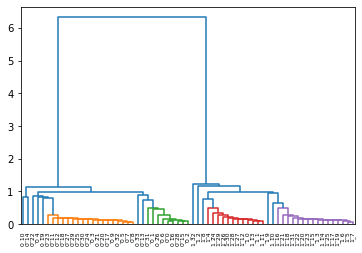

In [10]:
den = dc.dendro_cluster(mean_af, g, 0.6)

# cluster_classes = dc.get_cluster_classes(den)
curr_clones_dendro = dc.add_cluster_labels(mean_af,den,curr_clones)
curr_clones_dendro

size_pvals = dc.cluster_stats(curr_clones_dendro, out_f=None)

curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
curr_clones

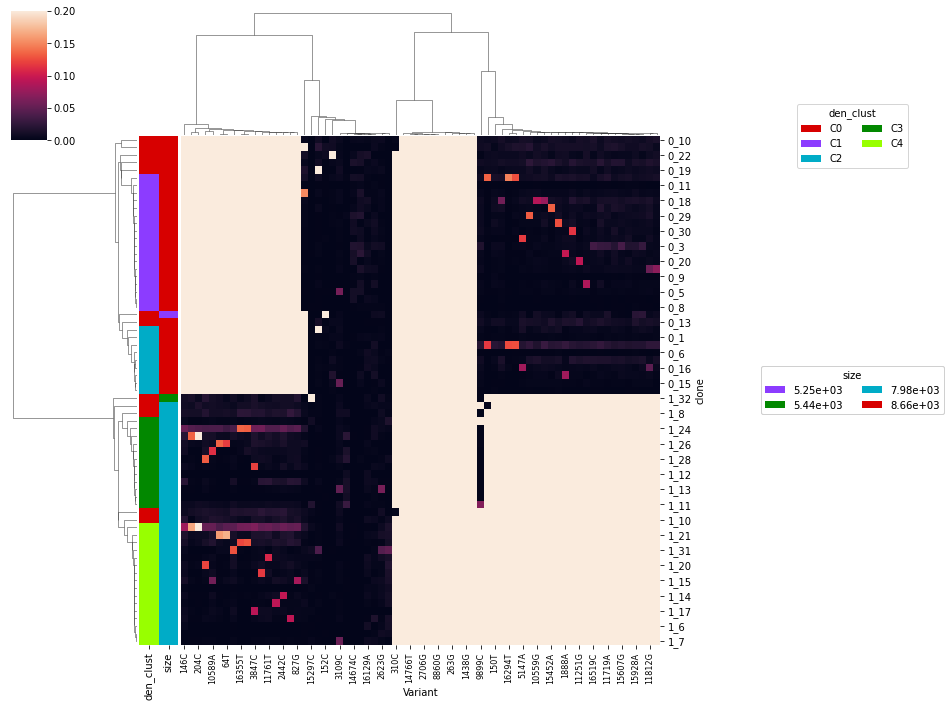

In [11]:
ch.plot_cluster(mean_af, row_meta=curr_clones[["den_clust", "size"]], vmax=0.2, vmin=0)
#fu.helper_save(out_f+"withEnrichmentFoldChange.DENDROGRAM.NoCondition.clust.max2.AF.png",to_pdf=False)

## Load the somatic variants number of cells and merge across conditions

In [12]:
clone_som_d = {}
clone_som_vars_d = {}

for c in conditions:
    clone_som_d[c] = pd.read_csv(join(indir, c, "clones_alt_numCells.csv"), index_col=0)
    clone_som_vars_d[c] = pd.read_csv(join(indir, c, "clone_alt_numCells.variants.tsv"), sep="\t")
    clone_som_d[c]["condition"] = c
    clone_som_d[c]["name"] = clone_som_d[c].index

clone_som_df = pd.concat(clone_som_d, axis=0).reset_index(drop=True).fillna(0)
clone_som_merge_df = clone_som_df.drop("condition",axis=1).groupby("name").agg(sum)
clone_som_merge_df



## Process the variants 
clone_som_vars_df = pd.concat(clone_som_vars_d) #[conditions[0]].reset_index()
# for c in conditions[1:]:
#     clone_som_vars_df = pd.merge(clone_som_vars_df, clone_som_vars_d[c].reset_index(), how="outer" ) #, left_index=True, right_index=True, 
clone_som_vars_df = clone_som_vars_df.drop_duplicates().set_index("var")

clone_som_vars_df["Gene Name"] = clone_som_vars_df["Gene Name"].fillna("")
clone_som_vars_df["Gene Name"] = clone_som_vars_df.apply(lambda x: x["Gene"] if x['Gene Name']=="" else x['Gene Name'] , axis=1)


In [13]:

clone_som_vars_df = clone_som_vars_df.reset_index().drop_duplicates(subset=["var", "Gene Name", "Feature_type", "Consequence"]).sort_values("Gene Name").iloc[::-1]

## For duplicated variants, add to gene
def dups(df):
    if df.shape[0] == 0:
        return df.iloc[0]

    cons = ";".join(list(set(df["Consequence"].values)))
    gene_name = ";".join(list(set(df["Gene Name"].values)))
    out = df.iloc[0]
    out["Consequence"] = cons
    out["Gene Name"] = gene_name
    out.name = None
    return out

clone_som_vars_df_rmdups = clone_som_vars_df.groupby("var").apply(dups)
clone_som_vars_df_rmdups = clone_som_vars_df_rmdups[["Gene Name", "Feature_type", "Consequence"]]



# A. Cluster with somatic variants and label by dendrogram
# B. Cluster with barcodes and color by somatic variants of high variability (need a threshold for the cutoff)

## A1.

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


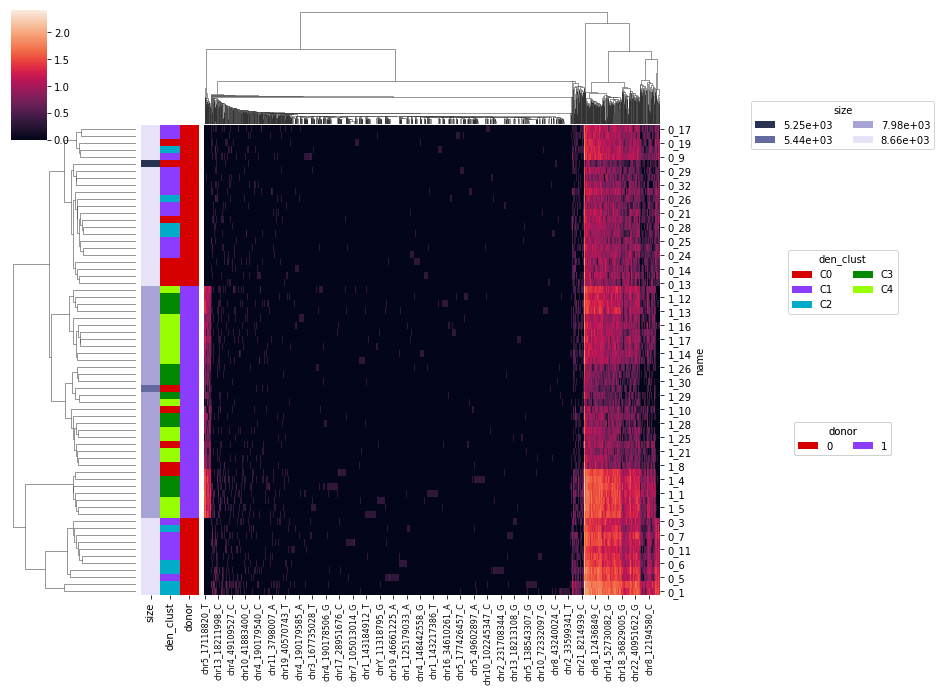

In [14]:
ch.plot_cluster(np.log10(clone_som_merge_df+1), row_meta=curr_clones.drop(conditions, axis=1), 
               row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})
plt.savefig(join(outdir, "som_vars_dendro.png")

## A2. With variants

Using only 16 of the labels for legend
Using only 16 of the labels for legend


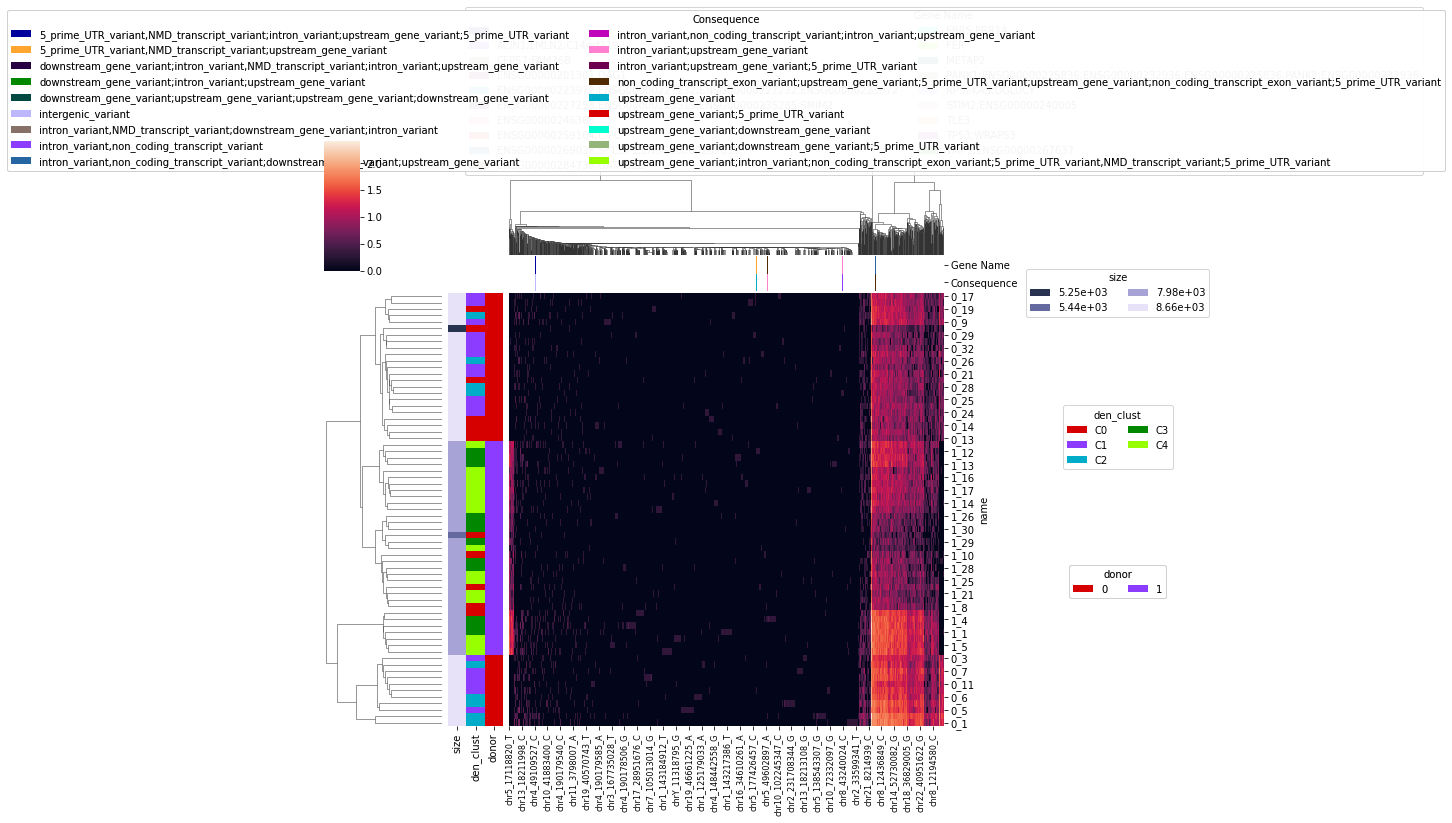

In [15]:
# ch.plot_cluster(np.log10(clone_som_merge_df+1), row_meta=curr_clones.drop(conditions, axis=1), 
#                row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"},
#                col_meta = clone_som_vars_df_rmdups.drop("Feature_type", axis=1))


In [16]:
# any all 0s?
(clone_som_merge_df==0).all().any()

False

## Split by donor

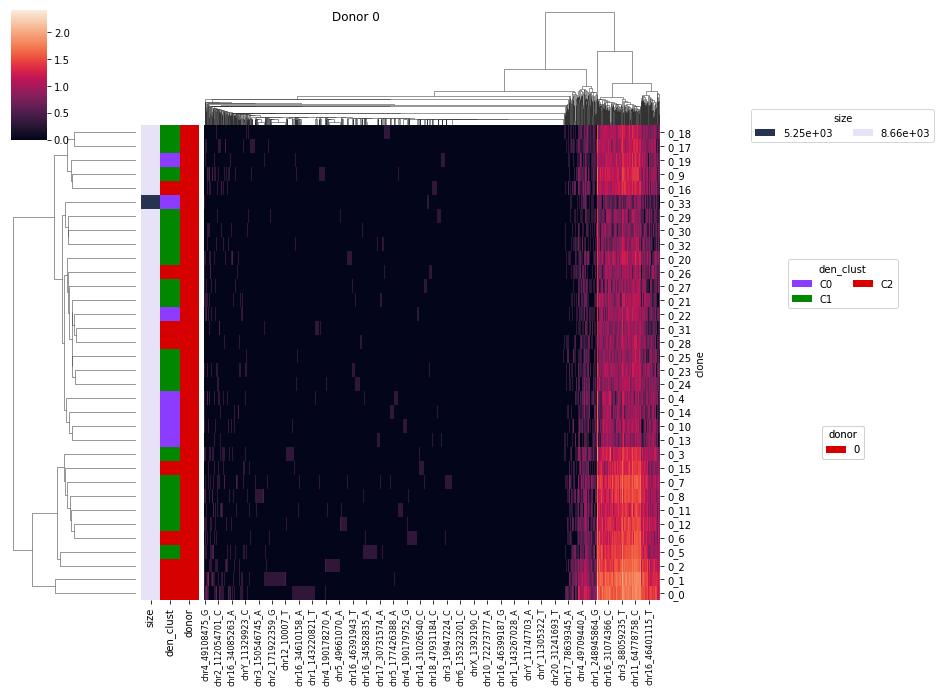

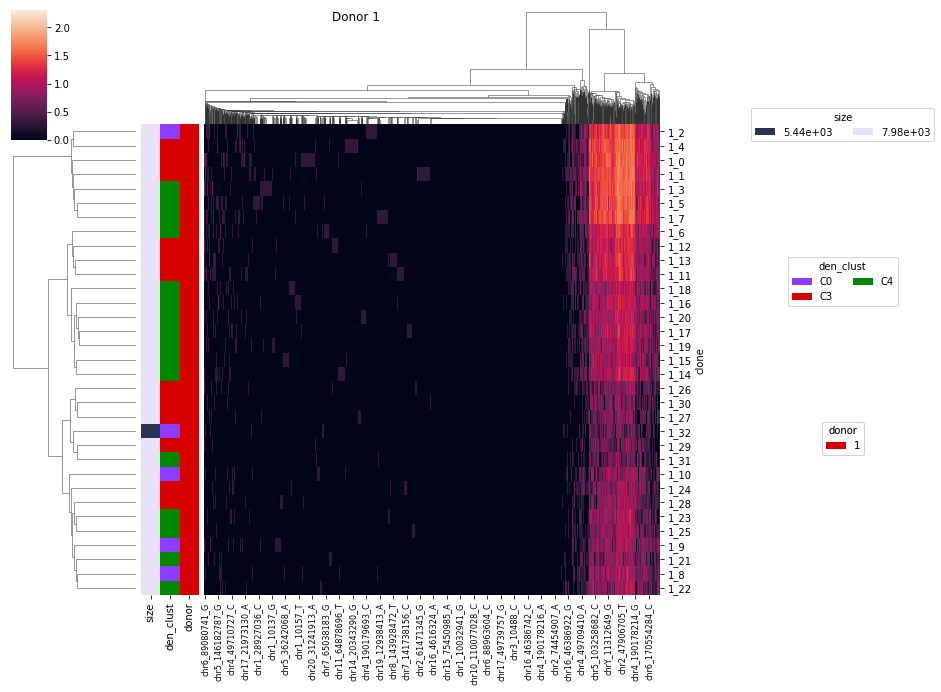

In [17]:
for d, curr_cl in curr_clones.groupby("donor"):
    curr_som = clone_som_merge_df.loc[curr_cl.index]
    ch.plot_cluster(np.log10(curr_som+1), row_meta=curr_cl.drop(conditions, axis=1), 
               row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})
    plt.suptitle(f"Donor {d}")
    plt.savefig(join(outdir, f"donor{d}_som_vars_dendro.png")

## Calculate high cv variants and plot those

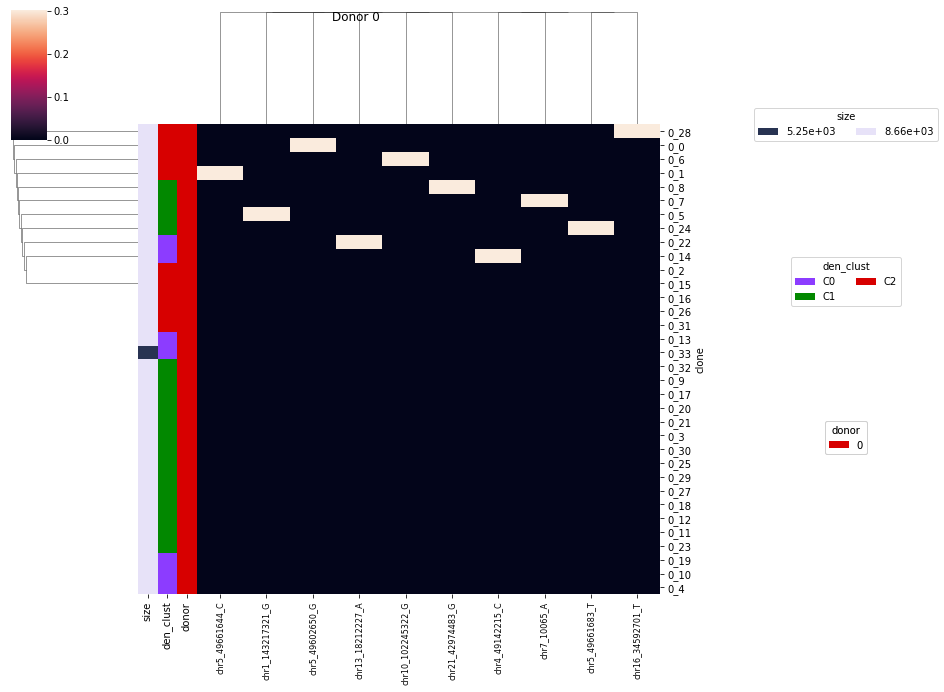

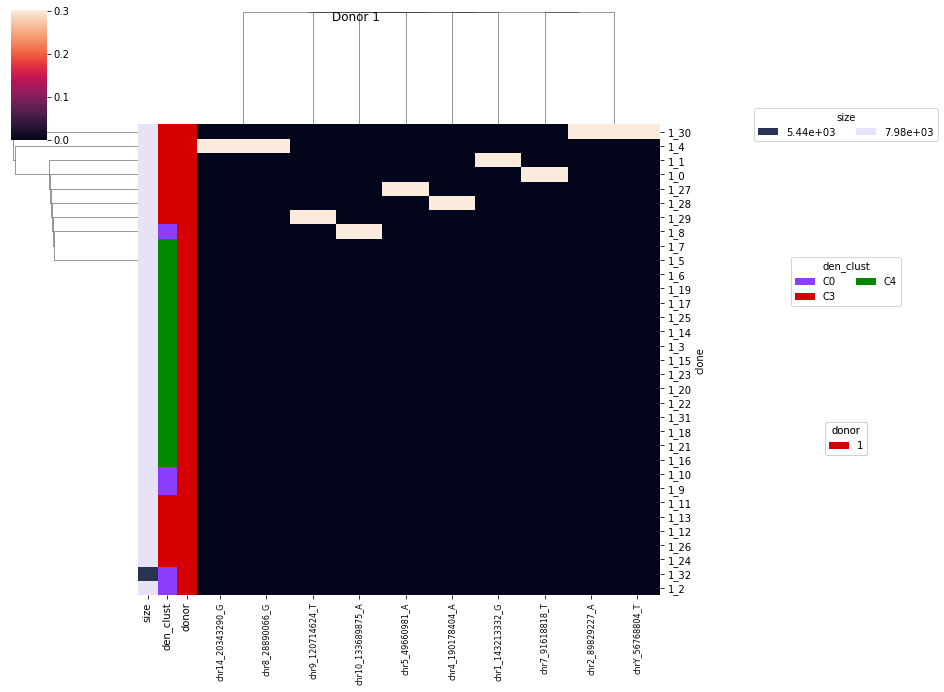

In [18]:
top_vars = 10
for d, curr_cl in curr_clones.groupby("donor"):
    curr_som = clone_som_merge_df.loc[curr_cl.index]
    
    curr_som = curr_som.loc[:, ~((curr_som==0).all())]
    curr_som = curr_som.iloc[:, scipy.stats.variation(np.log10(1+curr_som)).argsort()[::-1]]
    
    ch.plot_cluster(np.log10(curr_som.iloc[:,:top_vars]+1), row_meta=curr_cl.drop(conditions, axis=1), 
               row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})
    plt.suptitle(f"Donor {d}")
    plt.savefig(join(outdir, f"donor{d}_highCV_som_vars_dendro.png")

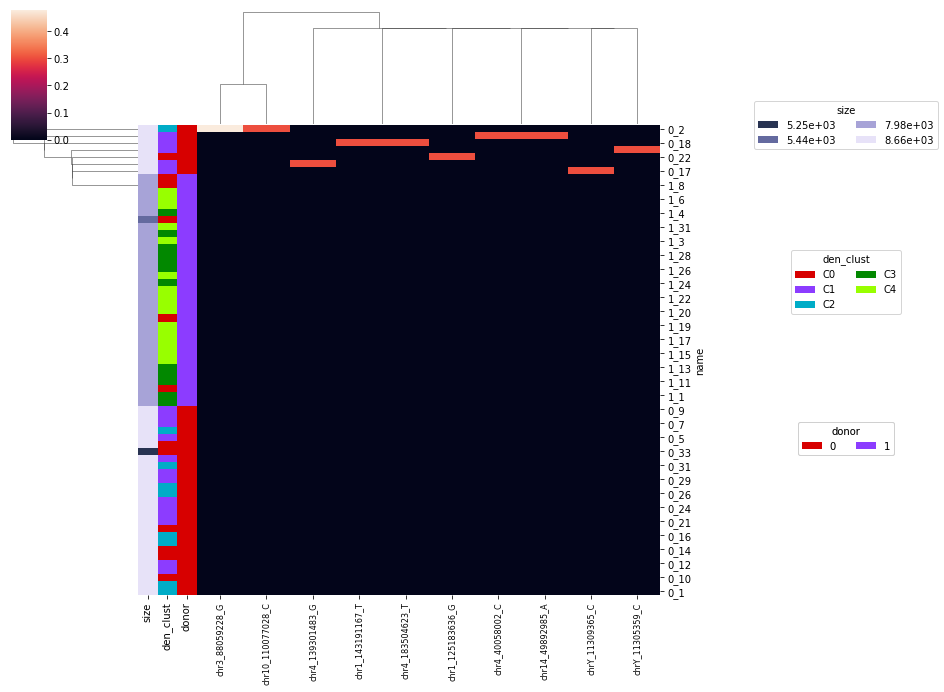

In [19]:
top_vars = 10

clone_som_merge_df = clone_som_merge_df.loc[:, ~((clone_som_merge_df==0).all())]
clone_som_merge_df = clone_som_merge_df.iloc[:, scipy.stats.variation(np.log10(1+clone_som_merge_df)).argsort()[::-1]]

ch.plot_cluster(np.log10(clone_som_merge_df.iloc[:,:top_vars]+1), row_meta=curr_clones.drop(conditions, axis=1), 
           row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})
plt.savefig(join(outdir, "highCV_som_vars_dendro.png")